In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 30 #higher precision
import csv
import json
from PyMatching import *

In [2]:
# #pymatching to compare to
# Ls = [4,6,8,10]
# ps = np.linspace(0.01, 0.12, 12)
# np.random.seed(2)

# for num_shots in range(2000, 30000, 2000):
#     log_errors_all_L = []
#     for L in Ls:
#         # print("Simulating L={}...".format(L))
#         Hx = toric_code_x_stabilisers(L)
#         logX = toric_code_x_logicals(L)
#         log_errors = []
#         for error_probability in ps:
#             num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
#             log_errors.append(num_errors/num_shots)
#         log_errors_all_L.append(np.array(log_errors))

#     plt.figure()
#     for L, logical_errors in zip(Ls, log_errors_all_L):
#         std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
#         plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))
#     plt.legend()
#     plt.title(f"Num shots: {num_shots}")
#     plt.show()

In [2]:
#Log sum exp with arbitrary precision governed by mp
#In particular this gives infinite temperature version of the free energy, for scaling
def log_sum_exp(to_sum):
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res

#Free energy given histogram and temperature, arbitrary precision governed by mp
def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

#Run over batch of results, structured by seed, then by class
def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

#For comparisons to MWPM algorithms
def get_lowest_energies(rescaled_results):
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:
            e_values = min(error_result[0])
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

#For comparisons to MWPM algorithms
def get_lowest_g(rescaled_results):
    lowest_g = []
    for seed_results in rescaled_results:
        lowest_g_classes = []
        for error_result in seed_results:
            g_values = min(error_result[1])
            lowest_g_classes.append(g_values)
        lowest_g.append(lowest_g_classes)
    return lowest_g

Here starts the processing of data inside json like txt files 

In [3]:
import re

def read_results_file(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")

    return data

def parse_file(filename):
    data = []
    try:
        with open(filename, 'r') as file:
            content = file.read()
            # print("file content printout (for debugging):")
            # print(content)
    except FileNotFoundError:
        return

    # Split content into individual blocks
    blocks = content.split('}\n{')  # Assuming blocks are separated by double newlines

    for block in blocks:
        # Extract histogram_seed, run_seed, and results
        histogram_seed_match = re.search(r'"histogram_seed": "(\d+)"', block)
        run_seed_match = re.search(r'"run_seed": "(\d+)"', block)
        results_match = re.search(r'"results": \[([^]]*)\]', block)

        if histogram_seed_match and run_seed_match and results_match:
            histogram_seed = histogram_seed_match.group(1)
            run_seed = run_seed_match.group(1)
            results_str = results_match.group(1)

            # Process results
            results = {}
            results_items = results_str.split(',')
            for item in results_items:
                key_value = item.split(':')
                if len(key_value) == 2:
                    key = key_value[0].strip().strip('"')
                    value = float(key_value[1].strip())
                    results[key] = value

            data.append({
                "histogram_seed": histogram_seed,
                "run_seed": run_seed,
                "results": results
            })

    return data

def process_data(data, batch_results, p, size, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append({
                'prob': p,
                'size': size,
                'error': error,
                'histogram_seed': histogram_seed,
                'run_seed': run_seed,
                'E': E_list,
                'log_g': log_g_list
            })
        # offset = log_sum_exp(log_g_list)
        # print('deviation from sqrt(2)xy: ', mp.log(2)*size*size - offset, ' log sum exp:', offset)

In [4]:
boundary_type = "periodic"
batch_results = []
probabilities = [0.1, 0.11, 0.12, 0.13]
sizes = [4, 6, 8, 10, 12]
intervals = [10, 40, 60]
iterations = 1000
overlap = 0.25
walkers = 8
alpha = 0.8
beta = 1e-8
exchange = 20

batch_results = []

for interval in intervals:
    for p in probabilities:
        for size in sizes:
            for error in ["I", "X", "Y", "Z"]:
                filename = f"../results/periodic/prob_{p:.6f}/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram_intervals_{interval}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset{exchange}.txt"
                try:
                    data = read_results_file(filename)
                    if data:
                        process_data(data, batch_results, p, size, error)
                except:
                    continue
print(len(batch_results))

431576


In [5]:
from collections import defaultdict

# only keep results which come with all different error types:
#Changing structure to match postprocessing and plotting

# grouped dictionary with keys prob size and hist seed
grouped_results = defaultdict(list)
for result in batch_results:
    key = (result['prob'], result['size'], result['histogram_seed'])
    grouped_results[key].append(result)

In [6]:
filtered_results = defaultdict(list)
for key, results in grouped_results.items():
    newkey = (key[0],key[1])
    errors = set(result['error'] for result in results)
    if errors == {'I', 'X', 'Y', 'Z'}:
        # To be removed once normalization is properly handled in c
        for result in results:
            log_g_list = result['log_g']
            offset = log_sum_exp(log_g_list)
            rescaled_log_g_list = [res + mp.log(2)*key[1]*key[1] - offset for res in log_g_list]
            result['log_g'] = rescaled_log_g_list
        filtered_results[newkey].append([[result['E'], result['log_g']] for result in results])
    # else:
    #     print(f"has issue with an error class prob: {key[0]} size: {key[1]} interaction seed: {key[2]} available errors: {errors}")

In [7]:
free_energies_batch = []
for p in probabilities:
    T_Nish = 1/(mp.log((1-p)/p)/2)
    temperatures = [1e-20,T_Nish,2*T_Nish, 8*T_Nish, 1e20]
    free_energies_size = []
    for size in sizes:
        batch_res = filtered_results[(p,size)]
        free_energies = get_free_energies(batch_res,temperatures)
        free_energies_size.append(free_energies)
        print('Number of seeds at p',p,', size',size,':', len(free_energies))
    free_energies_batch.append(free_energies_size)

Number of seeds at p 0.1 , size 4 : 6999
Number of seeds at p 0.1 , size 6 : 7000
Number of seeds at p 0.1 , size 8 : 0
Number of seeds at p 0.1 , size 10 : 10035
Number of seeds at p 0.1 , size 12 : 3
Number of seeds at p 0.11 , size 4 : 7000
Number of seeds at p 0.11 , size 6 : 7000
Number of seeds at p 0.11 , size 8 : 0
Number of seeds at p 0.11 , size 10 : 9794
Number of seeds at p 0.11 , size 12 : 8
Number of seeds at p 0.12 , size 4 : 7000
Number of seeds at p 0.12 , size 6 : 7000
Number of seeds at p 0.12 , size 8 : 0
Number of seeds at p 0.12 , size 10 : 9450
Number of seeds at p 0.12 , size 12 : 4
Number of seeds at p 0.13 , size 4 : 7000
Number of seeds at p 0.13 , size 6 : 7000
Number of seeds at p 0.13 , size 8 : 0
Number of seeds at p 0.13 , size 10 : 8904
Number of seeds at p 0.13 , size 12 : 8


In [23]:
import scipy

# Initialize the result dictionary to store (temperature, size, probability) as keys
results_dict = {}
lower_bounds_dict = {}
upper_bounds_dict = {}

# Loop over probabilities, sizes, and temperatures to compute and store the results
for i, p in enumerate(probabilities):
    for j, size in enumerate(sizes):
        free_energies = free_energies_batch[i][j]

        if len(free_energies) == 0:
            continue

        # Loop over temperatures
        for temp in temperatures:
            temp_idx = temperatures.index(temp)  # Get the index of the current temperature

            # Calculate res as before
            res = 1 - mp.fsum([
                f_class[0][temp_idx] < f_class[1][temp_idx] or
                f_class[0][temp_idx] < f_class[2][temp_idx] or
                f_class[0][temp_idx] < f_class[3][temp_idx]
                for f_class in free_energies
            ]) / len(free_energies)

            # Calculate number of successes and failures
            number_success = round(len(free_energies) * res)
            number_failure = len(free_energies) - number_success

            # Calculate lower and upper bounds for error bars
            lower_bound = res - scipy.stats.beta.ppf(0.025, 0.5 + number_success, 0.5 + number_failure)
            upper_bound = scipy.stats.beta.ppf(0.975, 0.5 + number_success, 0.5 + number_failure) - res

            # Store the results in the dictionaries
            results_dict[(temp, size, p)] = res
            lower_bounds_dict[(temp, size, p)] = lower_bound
            upper_bounds_dict[(temp, size, p)] = upper_bound

# Example of how to access results:
# res_value = results_dict[(temperature, size, probability)]
# lower_bound_value = lower_bounds_dict[(temperature, size, probability)]
# upper_bound_value = upper_bounds_dict[(temperature, size, probability)]


In [24]:
results_dict.keys()

dict_keys([(1e-20, 4, 0.1), (mpf('1.05210067721026971103263257546183'), 4, 0.1), (mpf('2.10420135442053942206526515092365'), 4, 0.1), (mpf('8.4168054176821576882610606036946'), 4, 0.1), (1e+20, 4, 0.1), (1e-20, 6, 0.1), (mpf('1.05210067721026971103263257546183'), 6, 0.1), (mpf('2.10420135442053942206526515092365'), 6, 0.1), (mpf('8.4168054176821576882610606036946'), 6, 0.1), (1e+20, 6, 0.1), (1e-20, 10, 0.1), (mpf('1.05210067721026971103263257546183'), 10, 0.1), (mpf('2.10420135442053942206526515092365'), 10, 0.1), (mpf('8.4168054176821576882610606036946'), 10, 0.1), (1e+20, 10, 0.1), (1e-20, 12, 0.1), (mpf('1.05210067721026971103263257546183'), 12, 0.1), (mpf('2.10420135442053942206526515092365'), 12, 0.1), (mpf('8.4168054176821576882610606036946'), 12, 0.1), (1e+20, 12, 0.1), (1e-20, 4, 0.11), (mpf('1.05210067721026971103263257546183'), 4, 0.11), (mpf('2.10420135442053942206526515092365'), 4, 0.11), (mpf('8.4168054176821576882610606036946'), 4, 0.11), (1e+20, 4, 0.11), (1e-20, 6, 0.1

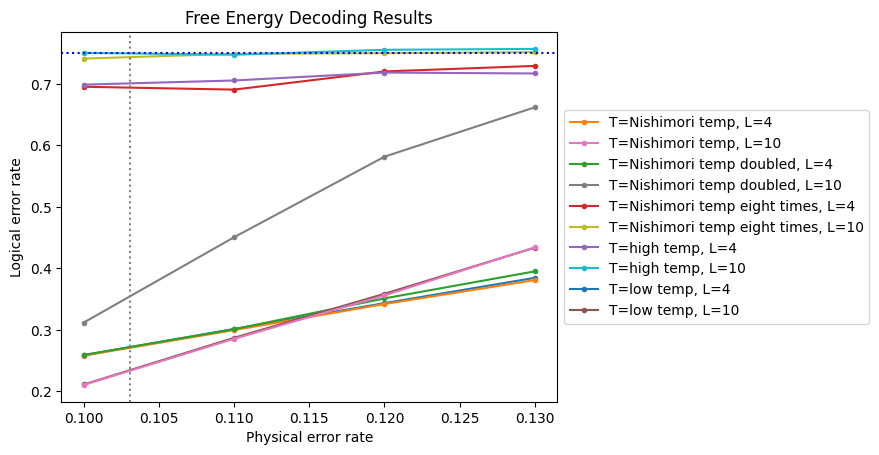

In [46]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# # Normalize temperatures to range between 0 and 1 for the colormap
# norm = plt.Normalize(min(temperatures), max(temperatures))
# cmap = plt.colormaps.get_cmap('Blues')   # Using the 'Blues' colormap

# Initialize the plot
plt.figure()

temperature_names = ['low temp','Nishimori temp','Nishimori temp doubled', 'Nishimori temp eight times', 'high temp']

handles = []
labels = []

# Loop through the unique sizes and temperatures
for size in sizes:

    for temp_idx, temp in enumerate(sorted(temperatures)):
        if size != 8 and size != 12 and size != 6:
            # Extract res values for the current size and temperature over all probabilities
            res_values = [1- results_dict[(temp, size, p)] for p in probabilities]

            # color = cmap(norm(float(temp)))

            # Plot the res curve for this combination of size and temperature
            line, = plt.plot(probabilities, res_values, ".-", label=f"Res for T={temp}, L={size}")

            # Store the line and label for the legend
            handles.append(line)
            labels.append(f"T={temperature_names[temp_idx]}, L={size}")


# Plotting threshold as a vertical line
plt.axvline(x=0.1031, color="gray", label="Expected MWPM threshold", linestyle="dotted")

# Labels and title
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.title(r"Free Energy Decoding Results")

plt.axhline(y=1-1/4,color="blue",label="Expected high temp error rate",linestyle="dotted")

# Sort the legend by temperature
sorted_indices = sorted(range(len(labels)), key=lambda i: labels[i].split('=')[1].split(',')[0])
handles = [handles[i] for i in sorted_indices]
labels = [labels[i] for i in sorted_indices]

# Add the legend with ordered entries
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [10]:
import scipy

optimal_curves = []
T0_curves = []

lower_bounds_T0 = []
upper_bounds_T0 = []

for i, p in enumerate(probabilities):
    optimal_curve = []
    T0_curve = []
    lower_bound_T0 = []
    upper_bound_T0 = []
    for j in range(len(sizes)):

       free_energies = free_energies_batch[i][j]

       if len(free_energies) == 0:
              continue

       #TO CHECK: if there is ever any significant difference between <= and < here
       #if so, should take degeneracy into account, and count with fraction if <=
       #Seems not to be an issue though
       temp = 1 #Nishimori temp
       res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
              or f_class[0][temp] < f_class[2][temp]\
              or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
       optimal_curve.append(res)

       temp = 0 #Low temp
       res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
              or f_class[0][temp] < f_class[2][temp]\
              or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
       T0_curve.append(res)

       number_success = round(len(free_energies) * res)
       number_failure = len(free_energies) - number_success

       lower_bound_T0.append(res-scipy.stats.beta.ppf(0.025, 0.5 + number_success, 0.5 + number_failure))
       upper_bound_T0.append(scipy.stats.beta.ppf(0.975, 0.5 + number_success, 0.5 + number_failure)-res)

    lower_bounds_T0.append(lower_bound_T0)
    upper_bounds_T0.append(upper_bound_T0)
    optimal_curves.append(optimal_curve)
    T0_curves.append(T0_curve)

In [11]:
# plt.figure()
# for L, logical_errors in zip(Ls, log_errors_all_L):
#     std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
#     plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))


for i, size in enumerate(sizes):
    if size == 12:
        continue
    plt.plot(probabilities, [1-optimal_curves[j][i] for j in range(len(probabilities))],".-",label=r"Optimal decoding for L=%d"%size)
    plt.plot(probabilities, [1-T0_curves[j][i] for j in range(len(probabilities))],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)
    plt.errorbar(probabilities, [1 - T0_curves[j][i] for j in range(len(probabilities))],
                 yerr=[[ upper_bounds_T0[j][i]  for j in range(len(probabilities))], [lower_bounds_T0[j][i] for j in range(len(probabilities))]],
                 fmt='+--', label=r"T=$10^{-20}$ free energy decoding for L=%d" % size, capsize=5)


plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
#plt.ylim(bottom=1e-4, top=None)
plt.title(beta)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

NameError: name 'optimal_curves' is not defined